<a href="https://colab.research.google.com/github/haosulab/ManiSkill/blob/koch-v1.1/examples/tutorials/koch_sim2real.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Koch v1.1 Sim2Real Tutorial (BETA)

This notebooks covers a general sim2real pipeline:
1. Setting up the sim environment
2. Setting up the real environment
2. Aligning cameras between sim and real
4. Training your agent with PPO
5. Zero-Shot Evaluation on real robot

Following the steps of this pipeline, you will replicate:

MS3 custom sim training


![](https://github.com/haosulab/ManiSkill/blob/koch-v1.1/docs/source/user_guide/tutorials/images/koch_grab_training.gif?raw=true) 

Zero-Shot Eval on real

![](https://github.com/haosulab/ManiSkill/blob/koch-v1.1/docs/source/user_guide/tutorials/images/koch_grabcube.gif?raw=true)

**Required Materials:**

The comprehensive list of physical items necessary for the real environment:
* local machine (local gpu not required)
* Koch v1.1 follower arm
* phone (or any device) camera 
* camera tripod TODO (xhin): show 3d printed tripod here
* 3D printed 2cm sidelength cube TODO (xhin): list stl here
* measuring tape / ruler (for camera alignment)

*We also use a single lightsource of white light in our real evaluation environment

**NOTE:**
* All GPU operations in this tutorial can run on Colab's free tier, but a local machine is still required for controlling the actual robot.
* This project currently is in a **beta release**, so not all features have been added in yet and there may be some bugs. If you find any bugs or have any feature requests please post them to our [GitHub issues](https://github.com/haosulab/ManiSkill/issues/) or discuss about them on [GitHub discussions](https://github.com/haosulab/ManiSkill/discussions/). We also have a [Discord Server](https://discord.gg/x8yUZe5AdN) through which we make announcements and discuss about ManiSkill.

To begin, prepare the colab environment by switching to a GPU environment (Runtime -> Change Runtime Type)

Then install/import necessary libraries:

In [ ]:
# setup vulkan
!mkdir -p /usr/share/vulkan/icd.d
!wget -q https://raw.githubusercontent.com/haosulab/ManiSkill/main/docker/nvidia_icd.json
!wget -q https://raw.githubusercontent.com/haosulab/ManiSkill/main/docker/10_nvidia.json
!mv nvidia_icd.json /usr/share/vulkan/icd.d
!mv 10_nvidia.json /usr/share/glvnd/egl_vendor.d/10_nvidia.json
!apt-get install -y --no-install-recommends libvulkan-dev

In [ ]:
# libraries
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    import site
    !pip install git+https://github.com/haosulab/ManiSkill.git@koch-v1.1
    site.main() # run this so local pip installs are recognized

# 1 Digital Twins Simulation Evironment

## 1.1 Understanding the Sim Env

Before we get to customizing our environments, lets first 
1. Create the default environment - used for all of the training and evaluations on our end
2. Understand robot input & output
3. Understand the sim robot controller
4. Control our sim robot

### 1.1.1 Making the Default Environment

/home/stao/miniforge3/envs/ms3-lerobot/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Warning GreenScreening is OFF: BaseDigitalTwinEnv contains no overlay images
simulation render:


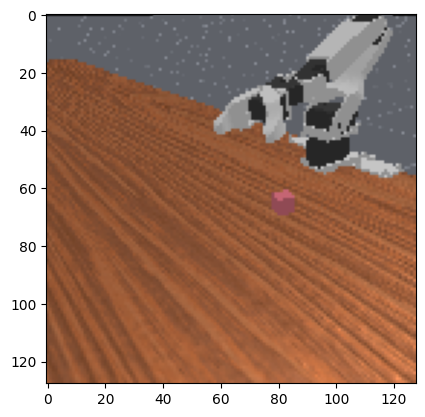

In [1]:
# Our imports
import mani_skill.envs
from mani_skill.utils.wrappers.flatten import FlattenRGBDObservationWrapper

# basic imports
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym

# Note: Warning aobut Greenscreening ok and will be covered in a later section
example_env_kwargs = dict(obs_mode="rgb+segmentation", render_mode="rgb_array", control_mode="pd_joint_delta_pos", num_envs=1, sim_backend="cpu")
sim_env = gym.make("GrabCube-v1", dr=False, **example_env_kwargs)
sim_obs, _ = sim_env.reset()

print("simulation render:")
plt.imshow(sim_env.render()[0])

### 1.1.2 Understanding Policy Input & Output

Observations are either state or camera observations

All state observations we use are available / estimatable during runtime in real

state observations:
qpos tensor([[ 0.0060,  2.2108,  2.7575, -0.2424, -1.5726,  0.9539]])
to_rest_dist tensor([[-0.0060, -0.0108, -0.0075, -0.0076,  0.0018]])
rest_qpos tensor([[ 0.0000,  2.2000,  2.7500, -0.2500, -1.5708]])
target_qpos tensor([[ 0.0060,  2.2108,  2.7575, -0.2424, -1.5726,  0.9539]])
is_grasped tensor([False])

camera observations:


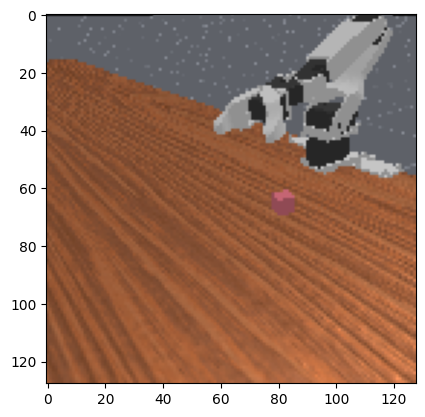

In [2]:
# Policy input example - observing the observations

# state observations
state_obs = sim_obs["extra"]
# camera observations
camera_obs = sim_obs["sensor_data"]["base_camera"]["rgb"][0].cpu()

print("state observations:")
for obs in state_obs:
    print(obs, state_obs[obs])
print() 
print("camera observations:")
plt.imshow(camera_obs); plt.show()

__A vigilant reader may notice that we use the state based boolean value of is_grasped in our observations__
* While this is priveledged state based info in sim, all state observations in real are functions of qpos and target_qpos
* In real, we estimate is_grasped by looking for a large difference in the target and actual qpos of the gripper joint. See [Section 6.1](#6-appendix) for the code implementation

Now, lets take a look at policy output:

In [3]:
# Policy output example - environment action space
sample_action = sim_env.action_space.sample()
print("sample_action", sample_action)
print("sample_action shape", sample_action.shape)

sample_action [-0.25411582 -0.34205547 -0.18428235 -0.44991502 -0.9055004   0.6889439 ]
sample_action shape (6,)


### 1.1.3 Policy Raw Output to Robot Control Conversion

We use MS3's pd_joint_target_delta_pos controller (best performance on real robot empirically), meaning:
* Policy (neural network) output logits are clipped between [-1,1] then scaled between ```lower``` and ```upper``` controller parameters
* The clipped and scaled output is used for target delta control, where:
    * qpos (length 6) are the current joint positions of the robot at each step
    * target_qpos (length 6) are the joint positons the robot is attempting to match at each step
    * these clipped and scaled outputs (also length 6) are added directly to target_qpos at each step

The config for the controller can be found in ```ManiSkill/mani_skill/agents/robots/koch/koch.py``` and looks like:
```python
pd_joint_target_delta_pos = PDJointPosControllerConfig(
    [joint.name for joint in self.robot.active_joints],
    lower=[-0.05, -0.05, -0.05, -0.05, -0.1, -0.05],
    upper=[0.05, 0.05, 0.05, 0.05, 0.1, 0.05],
    stiffness=[123, 50, 102.68, 145, 108.37, 93.3],
    damping=[15.85, 6, 15.34, 16, 16.31, 16.3],
    force_limit=100,
    use_delta=True,
    use_target=True,
)
```

We will reuse this exact controller for the real robot evaluation

### 1.1.4 Controlling The Sim Robot

rerun the following cell as many times as you'd like! (it may take many steps for noticeable difference)

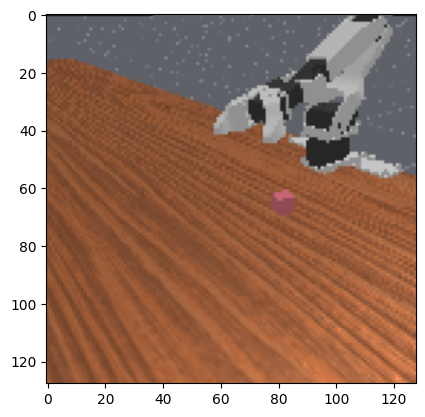

In [4]:
import numpy as np

#sim_env.reset() # uncomment this to reset the env, make it a comment to stop resetting

random_action = sim_env.action_space.sample()
close_gripper_only = np.array([0,0,0,0,0,-1.0])
action = close_gripper_only # try random_action also!
sim_obs, _, _, _, _ = sim_env.step(action)

plt.imshow(sim_obs["sensor_data"]["base_camera"]["rgb"][0].cpu())

## 1.2 Choosing Simulation Camera Parameters

To make your own digital twin... a twin, this pipeline estimates sim camera pose, by:

* Setting necessary LookAt transform parameters in sim: 
    * camera position
    * camera target position
    * camera fov
* Choosing 3D alignment point(s) for camera alignment:
    * set the alignment dot(s) so they span your simulation camera's field of view (i.e. they are not all in one place)
    * measuring them out carefully in real ([section 2](#2-setting-up-your-real-env))
* Aligning real camera pose(s) with sim, using our script ([section 3](#3-matching-real-camera-pose-with-sim-camera))

The following code cell sets the **_LookAt transform and camera alignment parameters_** for the simulated environment

* **We recommend leaving the default values for now, coming back to change them as necessary once you set up your real environment**

* **Differing camera positions are currently untested and may make perception more difficult**

**Note** Simulation: Coordinates are in meters, and they are centered at the robot's base (at the edge of the table, pictured below):

![](https://github.com/haosulab/ManiSkill/blob/koch-v1.1/docs/source/user_guide/tutorials/images/koch_base_pos.png?raw=true)

In [5]:
#### User parameters for LookAt transform####
# NOTE: all values are offsets from robot base position (see following cell)
robot_base_color = [0.95,0.95,0.95]

base_camera_pos = [0.40, 0 + 0.265, 0.1725]
camera_target = [0.2, 0, 0] # green dot in sim debug mode

# tune this according to your camera
# TODO (xhin): should honestly be a whole different section / reference a tutorial for camera intrinsics estimation
camera_fov = 52* (np.pi / 180)

# debug camera position points - appear if debug in rgb_overlay_mode, useful in camera alignment
# really only need 2, but more is helpful
alignment_dots = [ # yellow dots in sim debug mode
    [0.2,  0.10, 0], ## close to camera
    [0.2,  -0.1, 0], ## far from camera
    [0.35, 0.00, 0], ## far infront of robot
    [0.35, 0.10, 0], ## far infront of robot and close camera
]
#### End User parameters ####

Warning GreenScreening is OFF: BaseDigitalTwinEnv contains no overlay images

Visualization of camera alignment dots: Alignment dots appear if env 'debug' mode is on
The Green dot marks camera lookat target (center of rendered image)
Yellow dots mark camera alignment dots


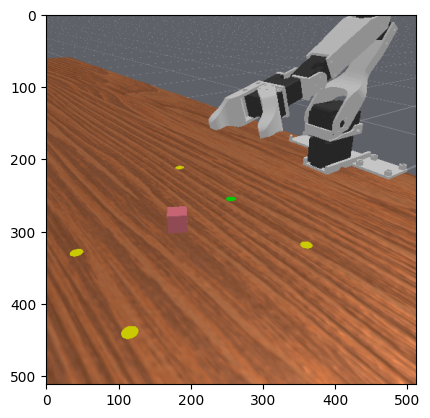

In [6]:
# Render with Camera Parameters
dubug = True # toggles visibility of alignment dots
# all user params from cell above applied via env kwargs
example_env_kwargs.update(robot_base_color=robot_base_color,
                          base_camera_pos=base_camera_pos,
                          camera_target=camera_target,
                          camera_fov=camera_fov,
                          alignment_dots=alignment_dots)
sim_env = gym.make("GrabCube-v1", dr=False, debug=dubug, **example_env_kwargs)
sim_obs, _ = sim_env.reset(seed=1)


sim_env.unwrapped.toggle_greenscreen(False) # covered in section 1.3
env_render = sim_env.render().cpu()
print()
print("Visualization of camera alignment dots: Alignment dots appear if env 'debug' mode is on")
print("The Green dot marks camera lookat target (center of rendered image)")
print("Yellow dots mark camera alignment dots")
plt.imshow(env_render[0]); plt.show()

## 1.2.2 Saving Custom Env Params to Disk
* The cell below stores the custom parameters you just set in a json file to use later for camera alignment

In [7]:
sim_env.unwrapped.save_user_kwargs("user_kwargs.json")

## 1.2.3 Domain Randomizations:

A deeper-dive into domain randomizations and their valuse can be found in [section 6.2](#62-implemented-domain-randomization)

However, a comprehensive list of randomizations already implemented is:
- robot color
- robot pose
- camera position
- camera lookat position
- camera rotation about the viewing direction
- subscene lighting
- cube color
- cube friction


## 1.3 GreenScreening in ManiSkill3

We can overlay our robot and scene actors on any image we like, for example: a green-screen
* MS3 stores segmentation data available during rasterization, at each rendering step
* Later, we use the real environment background (from step 3) for simulation training

Green-Screening off


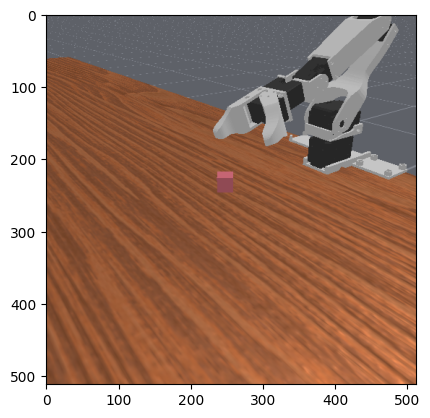

Green-Screening On (render resolution adjusted to env observation res 128x128)


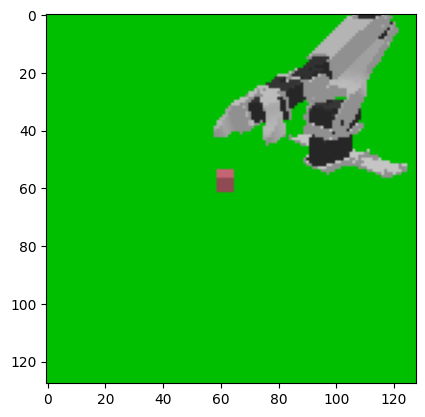

In [8]:
# create a "green-screen"
dummy_greenscreen = np.zeros((128,128,3))
dummy_greenscreen[:,:,1] = 0.75
plt.imsave("dummy_greenscreen.png", dummy_greenscreen)

# temporarily turn off domain randomiations
domain_rands = False

# now we can create the sim environment, and view it
# obs_mode="rgb+segmentation" required for greenscreening 
# reusing user params saved within example_env_kwargs 
sim_env = gym.make("GrabCube-v1", rgb_overlay_path="dummy_greenscreen.png", dr=domain_rands, **example_env_kwargs)
sim_obs, _ = sim_env.reset(seed=0)

# view the simulation renders

# toggle off greenscreening for render - note that greenscreening for sim_env.get_obs() stays on!
# greenscreening activated by default
sim_env.unwrapped.toggle_greenscreen()
print("Green-Screening off")
plt.imshow(sim_env.render().cpu()[0]); plt.show()

# toggle back on greenscreeening
sim_env.unwrapped.toggle_greenscreen()
print("Green-Screening On (render resolution adjusted to env observation res 128x128)")
plt.imshow(sim_env.render().cpu()[0]); plt.show()

In [9]:
# the greenscreen can be anything we'd like
!wget -O other_greenscreen.png https://www.dinehq.com/uploads/maniskill.png > /dev/null 2>&1
sim_env.unwrapped.set_overlay(camera_name="base_camera", path="other_greenscreen.png")
print("Green-Screen Changed (render resolution adjusted to env observation res 128x128)")
plt.imshow(sim_env.render().cpu()[0]); plt.show()

^C


error: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


# 2 Setting Up your Real Env

## 2.0 Setting up your Koch v1.1

### 2.0.1 Before We Can Start

1. You first need to follow [Lerobot's tutorial for the Koch v1.1 robot setup](https://github.com/huggingface/lerobot/blob/380b836eee5f7cd61f023ef09dd5e0d9721d8c54/examples/7_get_started_with_real_robot.md). It will result in the creation of a calibration directory under ```.cache/calibration/koch``` required for this tutorial.

2. Once finished, git clone MS3 on local: ```git clone https://github.com/haosulab/ManiSkill.git```
3. Finally, move the calibration directory under ```.cache/calibration/koch``` into the parent of the local, cloned root directory: ```ManiSkill/..```
4. 3D print cube(s) using our stl: TODO xhin: add stl and path here


### 2.0.2 Compatibility for MS3

Next, find our koch real robot wrapper in ```mani_skill/envs/tasks/digital_twins/real_agents/koch.py```

Update the ports, cameras, and calibration directory as needed:

```python
class MS3RealKoch(BaseRealAgent):
    ...
    def _load_agent(self, **kwargs):
        """Conect the robot"""
        robot_config = KochRobotConfig(
            leader_arms={},
            follower_arms={
                "main": DynamixelMotorsBusConfig(
                    port="/dev/ttyACM0", # <-- UPDATE HERE
                    motors={
                        # name: (index, model)
                        "shoulder_pan": [1, "xl430-w250"],
                        "shoulder_lift": [2, "xl430-w250"],
                        "elbow_flex": [3, "xl330-m288"],
                        "wrist_flex": [4, "xl330-m288"],
                        "wrist_roll": [5, "xl330-m288"],
                        "gripper": [6, "xl330-m288"],
                    },
                ),
            },
            cameras={
                "base_camera": OpenCVCameraConfig(
                    camera_index=2,  # <-- UPDATE HERE
                    fps=60,
                    width=640,
                    height=480,
                    rotation=90,  # <--- <-- UPDATE HERE If Necessary
                ),
            },
            calibration_dir="koch_calibration",  # <-- UPDATE HERE
        )
        robot = ManipulatorRobot(robot_config)
        robot.connect()
        return robot
```

Note that the leader arms is left empty - you will not need the leader arm for this tutorial

The MS3RealKoch wrapper makes the real koch-v1.1 robot compatible with ManiSkill3 trained policies, mainly it:
- Handles formatting of RGB and proprioceptive observations for policy input
- Allows use of ManiSKill3's controllers on the real robot

If you're curious, feel free to look deeper into the wrapper at  ```mani_skill/envs/tasks/digital_twins/real_agents/koch.py```. 

## 2.1 Drawing the Alignment Dots
* Draw the alignment dots from sim in [section 1.2](#12-choosing-simulation-camera-parameters) on your real table (more accurate) or place your choice of removable markers on the 3D alignment points we passed into the environment earlier
    * Color/shape/size doesn't matter here, this is only for aligning the camera
    * measure them out with their exact coordinates from 1.2
        - ex: [0.35, 0.10, 0.0] is 35 cm in front and 10 cm to the right of the robot (closest dot to camera in pictured below)
* Similarly, draw/place a dot for the camera target position
* Finally, measure and place your camera at chosen 3D point, and roughly align it to scene (camera alignment in [section 3](#3-matching-real-camera-pose-with-sim-camera))

After this step, our setup looks like this:

![](https://github.com/haosulab/ManiSkill/blob/koch-v1.1/docs/source/user_guide/tutorials/images/koch_real_init.png?raw=true)

**Note:** you do not need to perfectly pinpoint this robot base position
* An estimate point on the edge of the table will suffice; the robot can be further adjusted during camera alignment in [section 3](#3-matching-real-camera-pose-with-sim-camera). 

**Reminder** Coordinates are in meters, and they are centered at the robot's base (at the edge of the table, pictured below):
* Measure out the alignment dots using the values set (default or your chosen values) in [section 1.2](#12-choosing-simulation-camera-parameters), centered at point visualized below
* If the default values are incompatible with your setup requirements, this is where you would change the camera setup parameters in [section 1.2](#12-choosing-simulation-camera-parameters)

![](https://github.com/haosulab/ManiSkill/blob/koch-v1.1/docs/source/user_guide/tutorials/images/koch_base_pos.png?raw=true)



# 3 Matching Real Camera Pose with Sim Camera

The following script overlays the simulation actors onto your real world setup

1 Download and paste ```user_kwargs.json``` from this colab into the local ```ManiSkill/..``` directory, for custom env replication on local

2 On local and within the parent of the cloned root directory: ```ManiSkill/..```
* plug in your camera & follower arm
* Run: ```python3 ManiSkill/mani_skill/envs/tasks/digital_twins/utils/camera_setup.py --user_kwargs_path=user_kwargs.json```
    * You will be prompted to press 'Enter' before the robot moves to the initial pose of the environment


Our Aligment process looks like:

![](https://github.com/haosulab/ManiSkill/blob/koch-v1.1/docs/source/user_guide/tutorials/images/koch_cam_align.gif?raw=true)


## 3.2 Taking the Greenscreen Photo

Once you have aligned your camera, you can take the background photo for greenscreened simulation training:
* Move your koch_v1.1 follower arm out of camara view
* Run ```python3 ManiSkill/mani_skill/envs/tasks/digital_twins/utils/camera_setup.py --output_photo_path=<your_path_here>.png```

This will output a photo at ```<your_path_here>_base_camera.png```

If you're in Colab:
* Copy and paste this photo into the colab files for simulation training in next step

Feel free to re-run camera alignment from previous step to move koch_v1.1 back into its proper place, without moving the camera

Our final background image looks like (yours may be 128x128 instead): 

![](https://github.com/haosulab/ManiSkill/blob/koch-v1.1/docs/source/user_guide/tutorials/images/koch_example_greenscreen.png?raw=true)

Now, visualize your final greenscreen in sim:

In [ ]:
colab_greenscreen_path = ... # put your path here
example_env_kwargs.update(rgb_overlay_path=colab_greenscreen_path)
sim_env = gym.make("GrabCube-v1", dr=False, **example_env_kwargs)
sim_obs, _ = sim_env.reset(seed=0)
plt.imshow(sim_obs["sensor_data"]["base_camera"]["rgb"][0])

Re-save the user_kwargs for the environment, this saves your greenscreen path as well - to be used for training

In [17]:
sim_env.unwrapped.save_user_kwargs("user_kwargs.json")

# 4 Training your Agent in Sim

MS3 provdes an array of rl training scripts within ```ManiSkill/examples/baselines```

Below, we provide an example using the modules from MS3's ```ppo_rgb.py``` to train an agent with the environment you created

In [ ]:
!wget https://raw.githubusercontent.com/haosulab/ManiSkill/koch-v1.1/examples/baselines/ppo/ppo_rgb.py -O ppo_rgb.py

To get started first download the RL code as done below and import some packages

In [2]:
from IPython.display import Video

The cell below opens tensorboard on colab so you can watch training metrics.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir runs

Before running the script, change the colab to a GPU environment (Runtime -> Change Runtime Type)

Evaluation rollout videos and model checkpoints will populate in the runs directory

In [ ]:
!python3 ppo_rgb.py --env_id="GrabCube-v1" --num_envs=256 \
    --update_epochs=4 --num_minibatches=8 --total_timesteps=15_000_000 \
    --num-steps=75 --num_eval_steps=75 --gamma=0.90 \
    --no_partial_reset --render_mode=rgb_array --reconfiguration_freq=1 \
    --obs_mode=rgb+segmentation --seed=0 --no_finite_horizon_gae \
    --exp_name=grab_cube_training --user_kwargs_path=user_kwargs.json 

# 5 Policy Evaluation on Real

## 5.1 Safe Evaluation

**NOTE**: Before running any scripts with the real robot, we suggest you ensure that your ports are correctly listed in the ```mani_skill/envs/tasks/digital_twins/real_agents/koch.py``` file. Use the ```find_motors_bus_port.py``` script from lerobot and re-permit use of the ports on local with chmod if necessary, then plug in your robots

You can evaluate any checkpoint from training directly on the real robot:
* Copy and paste the checkpoint, e.g. ckpt_776.pt, into your local directory of choice <your_dir>
* Run the following script on local - the debug flag requires you to press enter at every environment step
```
python3 ManiSkill/mani_skill/envs/tasks/digital_twins/utils/real_ppo_agent_eval.py --real_env_id="RealGrabCube-v1" --control_mode="pd_joint_delta_pos" --num_eval_steps=200 --checkpoint=<your_dir>/ckpt_776.pt --debug
```

##  5.2 Normal Evaluation

**Warning**: Be ready to unplug / control-c / stop the script at any time; it is the user's responsibility to ensure the robot does not hurt its own joints via colliding with the table, etc. There is no guarentee the policy will properly transfer to real. We recommend thourough evaulation with --debug flag before this step.

The simulation training and recommended evaluation frequence is 15hz. To evaluate at 15hz, run:

```python3 ManiSkill/mani_skill/envs/tasks/digital_twins/utils/real_ppo_agent_eval.py --real_env_id="RealGrabCube-v1" --control_mode="pd_joint_delta_pos" --num_eval_steps=200 --checkpoint=<your_dir>/ckpt_776.pt --control_freq=15```


##  5.3 Our Evaluations:

Our evaluations using this tutorial can be found in [ManiSkill3's Demo Gallery](https://maniskill.readthedocs.io/en/latest/user_guide/demos/gallery.html#vision-based-zero-shot-sim2real-manipulation)

# 6 Appendix:

## 6.1 The Real Env - 'is grasped' observation

Below, we show the proprioceptive observations used in our real environment, within
 ```ManiSkill/mani_skill/envs/tasks/digital_twins/affordable_arms_tabletop/real_tasks/real_grab_cube.py```:

```python
@register_env("RealGrabCube-v1", max_episode_steps=75)
class RealGrabCubeEnv(BaseRealEnv):
    real_agent_cls = MS3RealKoch
    ...
    # NOTE: In emulating maniskill environments, batching obs with batchsize=1 is required
    # agent qpos is already included in state observations, from BaseRealEnv
    def _get_obs_extra(self):
        qpos = common.batch(self.agent.qpos.clone())
        target_qpos = self.agent.controller._target_qpos.clone()
        is_grasped = ((qpos[..., -1] - target_qpos[..., -1]) >= 0.02).float() * (
            target_qpos[..., -1] < 0.24
        )
        obs.update(
            qpos=qpos,
            target_qpos=target_qpos,  # already a batched torch tensor: (1, #joints)
            rest_qpos=common.batch(
                self.robot_keyframe_qpos[:-1].clone()
            ),  # already a torch tensor, need to batch: (#joints) -> (1, #joints)
            to_rest_dist=common.batch(
                self.robot_keyframe_qpos[:-1].clone() - qpos[0, :-1]
            ),
            is_grasped=is_grasped.view(1, 1),
        )
        return obs
```

The ```_get_obs_extra``` function includes all of the proprioceptive information fed to our policy at runtime

- is grasped is an estimate based on a delta between the current and target joint positions
- RGB observations are gathered and formattted by the MS3RealKoch wrapper

## 6.2 Implemented Domain Randomization:

Below, we show the default domain randomizations and their sampling values. Check out the full file for the full implemntation!

We split domain randomizations into task-agnostic and task specific for the development of future tasks

For the Koch arm (and future affordable arms), we use the Sim4RealBaseEnv in ```ManiSkill/mani_skill/envs/tasks/digital_twins/affordable_arms_tabletop/sim_tasks/sim4real_base_env.py``` for task-agnostic randomizations

```python
class Sim4RealBaseEnv(BaseDigitalTwinEnv):
    """
    Base environment for simulating affordable robot tasks
    General, non-task-specific randomizations to aid sim2real transfer
    Randomizations include:
        - robot color
        - robot pose
        - camera position
        - camera lookat position
        - camera rotation about the viewing direction
        - subscene lighting
    """
    def __init__( ... )
        ...
        ################ Task-Agnostic Randmoizations ################
        # robot color noise
        self.robot_color_noise = 0.05

        # robot pose randomizations
        self.robot_zrot_noise = (3 * np.pi / 180) * toggle_rand
        self.robot_y_noise = 0.01 * toggle_rand  # cm offset
        # camera randomizations
        self.max_camera_offset = [
            0.025 * toggle_rand,
            0.025 * toggle_rand,
            0.025 * toggle_rand,
        ]
        self.camera_target_noise = 1e-6
        self.camera_view_rot_noise = 5e-3 * toggle_rand
        self.camera_fov_noise_range = (
            2.0 * (np.pi / 180) * toggle_rand
        )  # max rad offset from camera_fov to sample from
        ################ End Task-Agnostic Randmoizations #############
        ...
```

The grab cube implementation can be found in ```ManiSkill/mani_skill/envs/tasks/digital_twins/affordable_arms_tabletop/sim_tasks/grab_cube.py``` 

We add a couple extra task-specific domain randomizations:
- cube size
- cube friction
- cube color

Actual values are shown below:

```python
# grab cube and return to rest keyframe
@register_env("GrabCube-v1", max_episode_steps=75)
class GrabCubeEnv(Sim4RealBaseEnv):
    # Task DR
    spawn_box_half_size = 0.1 / 2

    cube_size_mean = 0.017 / 2 # half size
    cube_size_std = 7e-4

    cube_friction_mean = 0.3
    cube_friction_std = 0.05

    rand_cube_color = True

    noise_qpos = True
```
